In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

from os import listdir
from os.path import isfile, join

Goals:
* see distibution for number of votes (for both games and users)
* investigate number of different "stats"
* check the proportion of imlicit and explicit feedback
* analyse how average ratings are changing through time
* check data sparcity
* check mean and median number of votes per user

In [2]:
os.getcwd()

'D:\\0Studia\\Data-Science-PW\\Masters-thesis\\scripts'

In [26]:
mypath = "D:/0Studia/Data-Science-PW\Masters-thesis/data/"
plot_savepath = "D:/0Studia/Data-Science-PW/Masters-thesis/images/empirical_plots/statistics_related/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles

['bgg_ratings_merged_filtered.csv',
 'bgg_ratings_merged_filtered_2015_10_500.csv',
 'explicit_train.csv',
 'games_data.csv',
 'implicit_train.csv',
 'leave_one_out_test.csv',
 'leave_one_out_validation.csv',
 'np_games_info.pkl',
 'ratings_chunk_1.csv',
 'ratings_chunk_2.csv',
 'ratings_chunk_3.csv',
 'ratings_chunk_4.csv',
 'ratings_chunk_5.csv',
 'tag_matrix.csr.npz',
 'tag_matrix.npz',
 'test_data_big',
 'train_data_big.npz',
 'val_data_big']

In [5]:
df = pd.read_csv(mypath+"bgg_ratings_merged_filtered_2015_10_500.csv")
print(f"number of obs = {df.shape[0]}")
df.head(3)

number of obs = 10994754


,Unnamed: 0,index,user_name,game_id,score,timestamp,stat_own,stat_preordered,stat_wishlist,stat_fortrade,stat_wanttoplay,stat_prevowned,stat_want,stat_wanttobuy
0,0,1,hsjx945,1,8.0,2019-08-27 10:20:16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,16859,hsjx945,3,7.3,2017-07-02 06:56:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,69289,hsjx945,5,0.0,2017-03-12 04:54:54,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_grouped_shape = df.groupby(["user_name", "game_id"]).count().reset_index().shape

if df_grouped_shape != df.shape:
    print("User-game pair from df are not unique.")
else:
    print("User-game pair from df are unique.")

User-game pair from df are unique.


## All data

In [7]:
# sparsity 
unique_users = df.user_name.unique()
unique_games = df.game_id.unique()
print(len(unique_users), len(unique_games))
print(df.shape[0])
df.shape[0] / (len(unique_users) * len(unique_games)) * 100

109084 2265
10994754


4.44996152184561

Index(['stat_own', 'stat_preordered', 'stat_wishlist', 'stat_fortrade',
       'stat_wanttoplay', 'stat_prevowned', 'stat_want', 'stat_wanttobuy'],
      dtype='object')

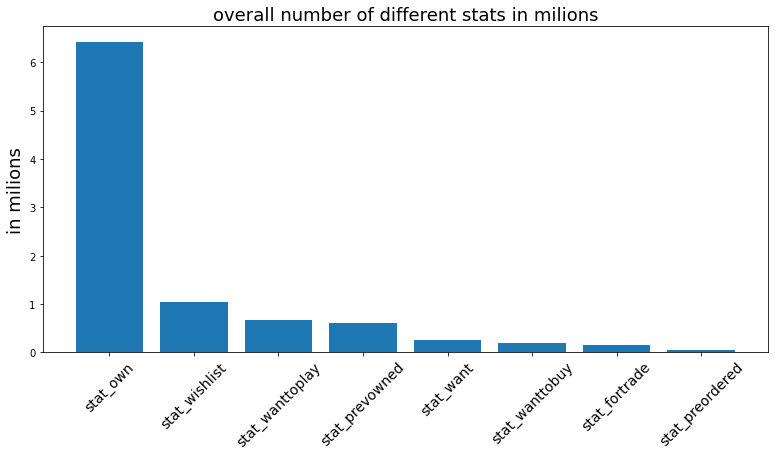

In [15]:
stats_count = (df.iloc[:,6:].sum(axis=0) / 10**6).sort_values(ascending=False)

plt.figure(figsize=(13,6))
plt.bar(stats_count.index, height=stats_count.values)
plt.title("overall number of different stats in milions", fontsize=18)
plt.ylabel("in milions", fontsize=18)
plt.xticks(rotation=45, fontsize=14)
plt.show()

In [30]:
# Separating implicit and explicit feedback
explicit = df[df.score!=0]
implicit = df[df.score==0]

In [35]:
implicit_users = (implicit.groupby("user_name")
                  .agg(implicit_intercations=("user_name", "count"))
                  .reset_index()
                 )

explicit_users = (explicit.groupby("user_name")
                  .agg(games_rated=("user_name", "count"),
                       highest_rating=("score", "max"),
                       avg_rating=("score", "mean"),
                       median_rating=("score", "median"))
                  .reset_index()
                 )

users = explicit_users.merge(implicit_users, on="user_name")
users["all_interactions"] = users.games_rated + users.implicit_intercations

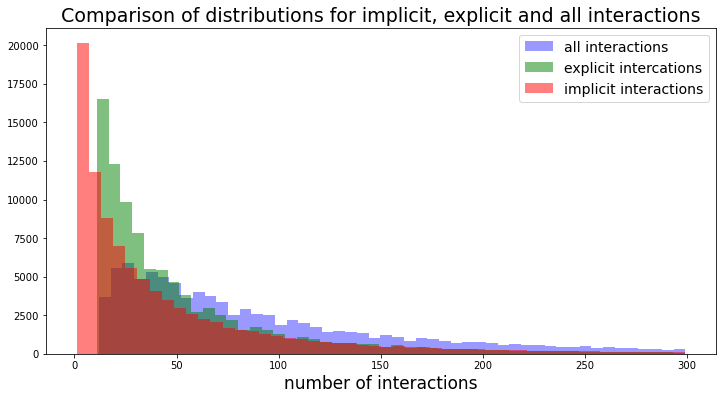

In [84]:
cutoff = 300
plt.figure(figsize=(12,6))

sns.distplot(users.all_interactions[users.all_interactions<cutoff], kde=0, color="blue")
sns.distplot(users.games_rated[users.games_rated<cutoff], kde=0, color="green", hist_kws={"alpha":0.5})
sns.distplot(users.implicit_intercations[users.implicit_intercations<cutoff], kde=0, color="red", hist_kws={"alpha":0.5})
plt.legend(["all interactions", "explicit intercations", "implicit interactions"], fontsize=14)
plt.title("Comparison of distributions for implicit, explicit and all interactions", fontsize=19)
plt.xlabel("number of interactions", fontsize=17)
plt.savefig(plot_savepath+"datasets-ratings-distribution.png")
plt.show()

## Explicit feedback

In [13]:
# sparsity
print(explicit.shape[0])
explicit.shape[0] / (len(unique_users) * len(unique_games)) * 100

6079248


2.460484307494

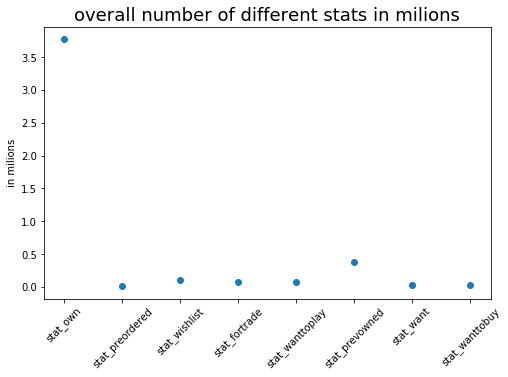

In [29]:
stats_count = explicit.iloc[:,6:].sum(axis=0) / 10**6

plt.figure(figsize=(8,5))
plt.plot(stats_count, "o")
plt.title("overall number of different stats in milions", fontsize=18)
plt.ylabel("in milions")
plt.xticks(rotation=45)
plt.show()

### Rating distribution

In [31]:
len(explicit[explicit.score<=5]) / len(explicit) * 100

9.188110108355508

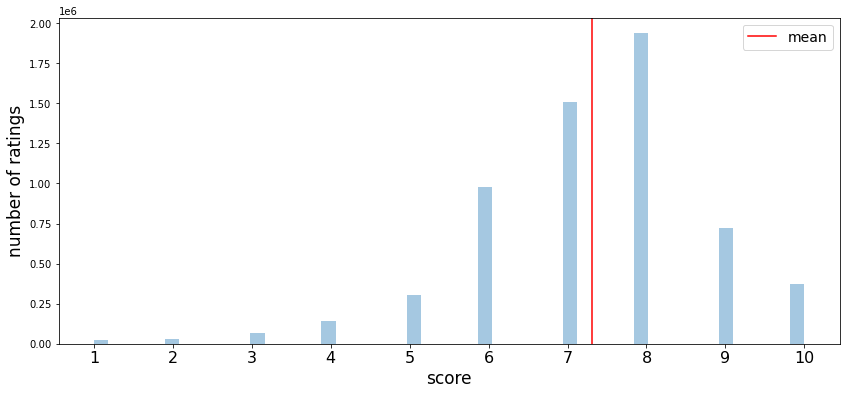

Median of the ratings = 7.0
Average rating = 7.31


In [33]:
r_mean = explicit.score.mean()
r_median = round(explicit.score).median()

plt.figure(figsize=(14, 6))
#plt.title("Rating distribution", fontsize=19)
sns.distplot(round(explicit.score), kde=0)
plt.axvline(r_mean, color = "red")
plt.legend(["mean"], fontsize=14)
plt.ylabel("number of ratings", fontsize=17)
plt.xlabel("score", fontsize=17)
plt.xticks(range(1,11), fontsize=16)
plt.savefig(plot_savepath+"explicit-rating-distribution.jpg")
plt.show()

print(f"Median of the ratings = {r_median}")
print(f"Average rating = {round(r_mean,2)}")

### Users 

In [68]:
for i in np.arange(0.1, 1, 0.1):
    print("Quantile", round(i,2), ":",explicit_users.games_rated.quantile(i))

Quantile 0.1 : 13.0
Quantile 0.2 : 17.0
Quantile 0.3 : 21.0
Quantile 0.4 : 27.0
Quantile 0.5 : 34.0
Quantile 0.6 : 43.0
Quantile 0.7 : 57.0
Quantile 0.8 : 78.0
Quantile 0.9 : 124.0


There are 4056 users with more than 200 games rated.


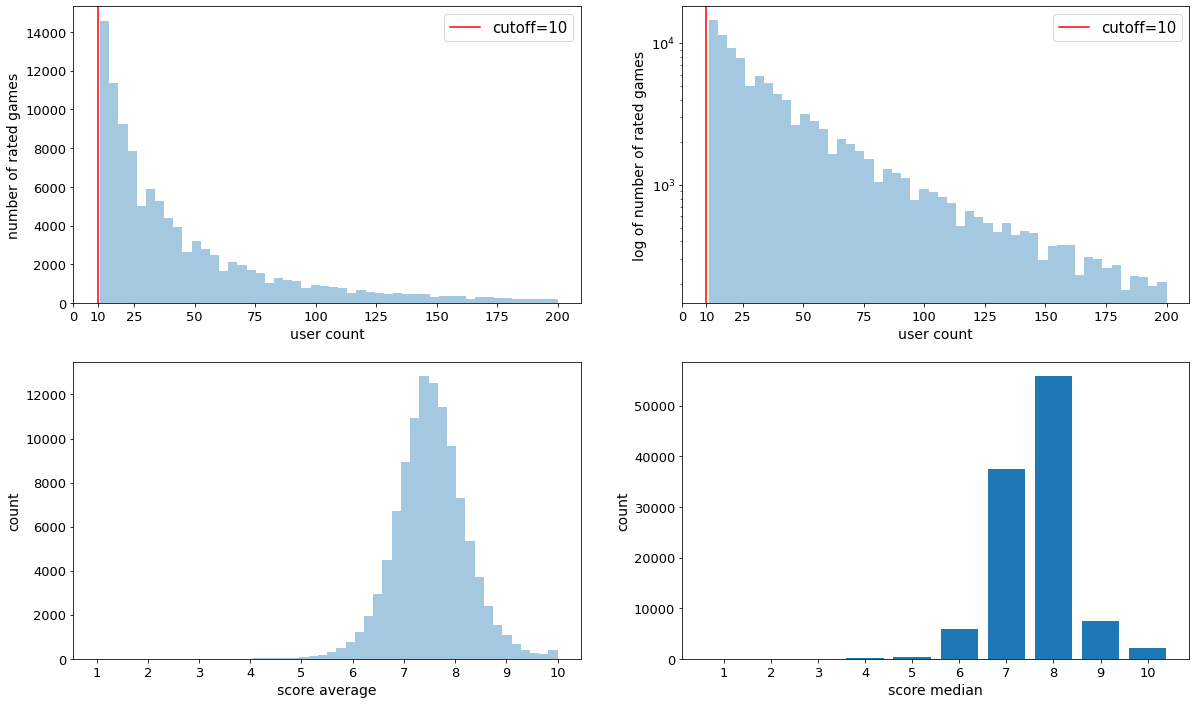

In [48]:
cutoff = 10
print(f"There are {len(explicit_users[explicit_users.games_rated>200])} users with more than 200 games rated.")

plt.figure(figsize=(20,12))

plt.subplot(221)
ax = sns.distplot(explicit_users.games_rated[explicit_users.games_rated<=200], kde=0)
plt.axvline(cutoff, color="red")
plt.ylabel("number of rated games", fontsize=14)
plt.yticks(fontsize=13)
x_ticks = [0, 10] + [25*i for i in range(1,9)]
plt.xticks(x_ticks, fontsize=13)
plt.xlabel("user count", fontsize=14)
#plt.title("Distribution of number of games rated, without long tail (cutoff=200)", fontsize=16)
plt.legend(["cutoff=10"], fontsize=15)

plt.subplot(222)
ax = sns.distplot(explicit_users[explicit_users.games_rated<=200].games_rated, kde=0)
ax.set_yscale('log')
plt.axvline(cutoff, color="red")
plt.yticks(fontsize=13)
plt.legend(["cutoff=10"], fontsize=15)
plt.ylabel("log of number of rated games", fontsize=14)
x_ticks = [0, 10] + [25*i for i in range(1,9)]
plt.xticks(x_ticks, fontsize=13)
plt.xlabel("user count", fontsize=14)
#plt.title("Distribution of log number of games rated, without long tail", fontsize=16)

plt.subplot(223)
sns.distplot(explicit_users.avg_rating, kde=0)
plt.ylabel("count", fontsize=14)
plt.xlabel("score average", fontsize=14)
plt.yticks(fontsize=13)
x_ticks = range(1,11)
plt.xticks(x_ticks, fontsize=13)
#plt.title("Distribution of avg_rating for users", fontsize=16)

plt.subplot(224)
median_data_users = explicit_users.median_rating.apply(lambda x: round(x))
median_data_users = median_data_users.value_counts()
plt.bar(median_data_users.index, height=median_data_users.values)
plt.xlabel("score median", fontsize=14)
plt.ylabel("count", fontsize=14)
plt.yticks(fontsize=13)
x_ticks = range(1,11)
plt.xticks(x_ticks, fontsize=13)
#plt.title("Distribution of mediain rating for users", fontsize=16)

plt.show()

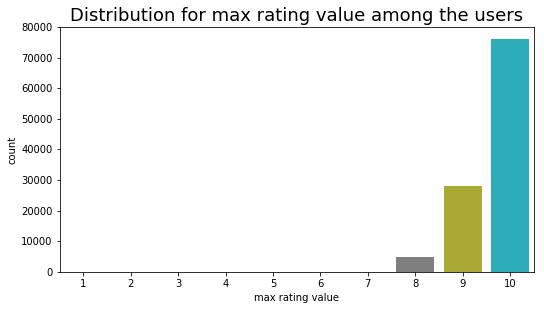

Number of users with highest ratings lower than 7 is equal to 6 (out of 10 users).


In [10]:
plt.figure(figsize=(8.5,4.5))
highest_rating_dist = explicit_users.highest_rating.apply(lambda x: round(x)).value_counts()
sns.barplot(x=highest_rating_dist.index, y=highest_rating_dist.values)
plt.title("Distribution for max rating value among the users", fontsize=18)
plt.ylabel("count")
plt.xlabel("max rating value")
plt.show()

low_max = highest_rating_dist[highest_rating_dist < 7].count()
print(f"Number of users with highest ratings lower than 7 is equal to {low_max} (out of {len(highest_rating_dist)} users).")

## Implicit feedback

In [18]:
implicit_unique_users = implicit.user_name.unique()
implicit_unique_games = implicit.game_id.unique()
print(len(implicit_unique_users), len(implicit_unique_games))
print(implicit.shape[0])
implicit.shape[0] / (len(implicit_unique_users)  * len(implicit_unique_games)) * 100

96173 2265
4915506


2.256559870757189

In [81]:
implicit.head()

,Unnamed: 0,index,user_name,game_id,score,timestamp,stat_own,stat_preordered,stat_wishlist,stat_fortrade,stat_wanttoplay,stat_prevowned,stat_want,stat_wanttobuy
2,2,69289,hsjx945,5,0.0,2017-03-12 04:54:54,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,512598,hsjx945,42,0.0,2017-12-26 10:31:59,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
13,13,6481883,hsjx945,4098,0.0,2019-03-22 19:22:06,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,17,9456405,hsjx945,12333,0.0,2017-02-11 05:37:30,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,19,1362280,hsjx945,19777,0.0,2017-06-02 05:57:39,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


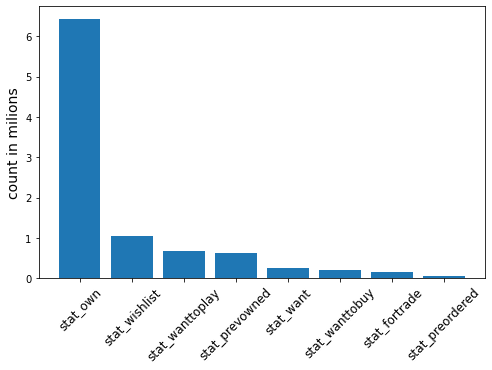

In [27]:
stats_count = (df.iloc[:,6:].sum(axis=0) / 10**6).sort_values(ascending=False)

plt.figure(figsize=(8,5))
plt.bar(stats_count.index, height=stats_count.values)
#plt.title("Overall number of different stats, Implicit dataset", fontsize=18)
plt.ylabel("count in milions", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.savefig(plot_savepath+"implicit-stats.png")
plt.show()

In [80]:
stats_count

stat_own           2.647337
stat_preordered    0.040112
stat_wishlist      0.950444
stat_fortrade      0.072411
stat_wanttoplay    0.595270
stat_prevowned     0.228208
stat_want          0.227053
stat_wanttobuy     0.170565
dtype: float64

In [74]:
stats_count.sum()*10**6, implicit.shape[0]

(4931400.0, 4915506)

In [78]:
tmp = implicit.iloc[:,6:].sum(axis=1)
tmp[tmp==0]

48          0.0
50          0.0
58          0.0
104         0.0
227         0.0
           ... 
10993500    0.0
10993602    0.0
10993969    0.0
10994478    0.0
10994635    0.0
Length: 465526, dtype: float64

## Games

In [24]:
games = pd.read_csv("/home/mmarzec12/data/games_data.csv")
games.head()

,Unnamed: 0,game_id,game_name,type,category
0,1,1,Die Macher,['Strategy'],"['Economic', 'Negotiation', 'Political']"
1,2,2,Dragonmaster,['Strategy'],"['Card Game', 'Fantasy']"
2,3,3,Samurai,['Strategy'],"['Abstract Strategy', 'Medieval']"
3,4,4,Tal der Könige,[None],['Ancient']
4,5,5,Acquire,['Strategy'],['Economic']


In [29]:
all_categories = set()
cats = games.category
for row in cats:
    for s in row[1:-1].split(", "):
        all_categories.add(s.rstrip(",").strip("'"))
        
all_categories.remove('')

In [35]:
len(all_categories)

85

In [11]:
s = games.category[0]

for i in s[1:-1].split():
    print(i.rstrip(",").strip("'"))

Economic
Negotiation
Political


In [7]:
s

"['Economic', 'Negotiation', 'Political']"

In [ ]:
#df["timestamp"] = pd.to_datetime(df.timestamp, format="%Y-%m-%d %H:%M:%S")
#df["rating_year"] = df.timestamp.dt.year


# yearly = df.groupby("rating_year").agg(ratings_count=("timestamp", "count"),
#                                       avg_rating=("score", "mean")).reset_index()

#plt.plot(yearly.rating_year[:-1], yearly.ratings_count[:-1], lw=4)
#plt.title("Number of ratings in given year")
#plt.xticks(yearly.rating_year[:-1], rotation=45)
#plt.show()

#plt.plot(yearly.rating_year[:-1], yearly.avg_rating[:-1], lw=4)
#plt.title("Average rating value in given year")
#plt.xticks(yearly.rating_year[:-1], rotation=45)
#plt.show()

## Validation set

In [11]:
mypath = "/home/mmarzec12/data/"
explicit = pd.read_csv(mypath+"explicit_train.csv")
implicit = pd.read_csv(mypath+"implicit_train.csv")

n_games = len(explicit.game_id.unique())

validation = pd.read_csv(mypath+"leave_one_out_validation.csv")
validation.score.mean()

9.390427353415742

In [12]:
explicit.shape, implicit.shape

((5861080, 3), (4915506, 14))

In [15]:
implicit.head()

,Unnamed: 0,index,user_name,game_id,score,timestamp,stat_own,stat_preordered,stat_wishlist,stat_fortrade,stat_wanttoplay,stat_prevowned,stat_want,stat_wanttobuy
0,2,69289,hsjx945,5,0.0,2017-03-12 04:54:54,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,512598,hsjx945,42,0.0,2017-12-26 10:31:59,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2,13,6481883,hsjx945,4098,0.0,2019-03-22 19:22:06,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17,9456405,hsjx945,12333,0.0,2017-02-11 05:37:30,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19,1362280,hsjx945,19777,0.0,2017-06-02 05:57:39,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [14]:
explicit.merge(implicit, on=["game_id", "user_name"])

,user_name,game_id,score_x,Unnamed: 0,index,score_y,timestamp,stat_own,stat_preordered,stat_wishlist,stat_fortrade,stat_wanttoplay,stat_prevowned,stat_want,stat_wanttobuy


In [17]:
test = pd.read_csv(mypath+"leave_one_out_test.csv")
test.score.mean()

9.627370842653411

**WHY?**<br/>
Here I want to check if by removing one highest rating I will not remove substantial amount of ratings for specific game. Because I do this two times, it can affect the amount of ratings that some games have (like a game that is super highly rated but is hard to get, so in consequence there is not much ratings for this game).

In [18]:
total_count = pd.DataFrame(df.game_id.value_counts()).reset_index()
validation_count = pd.DataFrame(validation.game_id.value_counts()).reset_index()
test_count = pd.DataFrame(test.game_id.value_counts()).reset_index()

total_count.columns = ['game_id', 'count']
validation_count.columns = ['game_id', 'count']
test_count.columns = ['game_id', 'count']

In [25]:
# Validation set vs all data
comparison_val = validation_count.merge(total_count, on="game_id", how="left", suffixes=('_validation', '_total'))
comparison_val["proportion"] = round(comparison_val.count_validation/comparison_val.count_total, 2)

comparison_val[comparison_val.proportion>=0.05].sort_values("proportion", ascending=False).merge(games, on="game_id")

,game_id,count_validation,count_total,proportion,Unnamed: 0,game_name,type,category
0,174430,3150,36052,0.09,174430,Gloomhaven,"['Strategy,', 'Thematic']","['Adventure', 'Exploration', 'Fantasy', 'Fight..."
1,167791,3327,50242,0.07,167791,Terraforming Mars,['Strategy'],"['Economic', 'Environmental', 'Industry / Manu..."
2,169786,3004,50252,0.06,169786,Scythe,['Strategy'],"['Economic', 'Fighting', 'Science Fiction', 'T..."
3,161936,2575,41115,0.06,161936,Pandemic Legacy: Season 1,"['Strategy,', 'Thematic']","['Environmental', 'Medical']"
4,84876,1432,30860,0.05,84876,The Castles of Burgundy,['Strategy'],"['Dice', 'Medieval', 'Territory Building']"
5,120677,1395,26979,0.05,120677,Terra Mystica,['Strategy'],"['Civilization', 'Economic', 'Fantasy', 'Terri..."
6,182028,1313,24873,0.05,182028,Through the Ages: A New Story of Civilization,['Strategy'],"['Card Game', 'Civilization', 'Economic']"
7,12333,1000,21970,0.05,12333,Twilight Struggle,"['Strategy,', 'Wargames']","['Modern Warfare', 'Political', 'Wargame']"
8,96848,909,18863,0.05,96848,Mage Knight Board Game,"['Strategy,', 'Thematic']","['Adventure', 'Exploration', 'Fantasy', 'Fight..."


In [27]:
# Test set vs all data
comparison_test = test_count.merge(total_count, on="game_id", how="left", suffixes=('_test', '_total'))
comparison_test["proportion"] = round(comparison_test.count_test/comparison_test.count_total, 2)

comparison_test[comparison_test.proportion>=0.05].sort_values("proportion", ascending=False).merge(games, on="game_id")

,game_id,count_test,count_total,proportion,Unnamed: 0,game_name,type,category
0,55690,1580,8387,0.19,55690,Kingdom Death: Monster,['Thematic'],"['Adventure', 'Fantasy', 'Horror', 'Mature / A..."
1,12333,3091,21970,0.14,12333,Twilight Struggle,"['Strategy,', 'Wargames']","['Modern Warfare', 'Political', 'Wargame']"
2,174430,4547,36052,0.13,174430,Gloomhaven,"['Strategy,', 'Thematic']","['Adventure', 'Exploration', 'Fantasy', 'Fight..."
3,96848,1483,18863,0.08,96848,Mage Knight Board Game,"['Strategy,', 'Thematic']","['Adventure', 'Exploration', 'Fantasy', 'Fight..."
4,115746,1018,12944,0.08,115746,War of the Ring (Second Edition),"['Thematic,', 'Wargames']","['Adventure', 'Fantasy', 'Fighting', 'Miniatur..."
5,167791,3987,50242,0.08,167791,Terraforming Mars,['Strategy'],"['Economic', 'Environmental', 'Industry / Manu..."
6,3076,1819,24709,0.07,3076,Puerto Rico,['Strategy'],"['City Building', 'Economic', 'Farming']"
7,31260,1811,24735,0.07,31260,Agricola,['Strategy'],"['Animals', 'Economic', 'Farming']"
8,37111,972,14256,0.07,37111,Battlestar Galactica: The Board Game,['Thematic'],"['Bluffing', 'Deduction', 'Movies / TV / Radio..."
9,28143,1147,19698,0.06,28143,Race for the Galaxy,['Strategy'],"['Card Game', 'Civilization', 'Economic', 'Sci..."


In [52]:
comparison = comparison_test.merge(comparison_val, on="game_id")
comparison["proportion"] = round((comparison.count_test + comparison.count_validation)/comparison.count_total_x, 2)
comparison = comparison[comparison.proportion>0.1].sort_values("proportion", ascending=False)\
             .merge(games, on="game_id")
comparison.rename(columns={"count_total_x":"total_count"}, inplace=True)

# games avg rating
games_avg_rating = df[df.score>0].groupby("game_id").agg(avg_rating=("score", "mean")).reset_index()
games_avg_rating["avg_rating"] = round(games_avg_rating["avg_rating"],2)

comparison = comparison.merge(games_avg_rating, on="game_id", how="inner")
print(comparison[["game_name", "proportion", "total_count", "avg_rating"]].to_latex())

\begin{tabular}{llrrr}
\toprule
{} &                                      game\_name &  proportion &  total\_count &  avg\_rating \\
\midrule
0  &                         Kingdom Death: Monster &        0.23 &         8387 &        8.39 \\
1  &                                     Gloomhaven &        0.21 &        36052 &        8.76 \\
2  &                              Twilight Struggle &        0.19 &        21970 &        8.22 \\
3  &                              Terraforming Mars &        0.15 &        50242 &        8.35 \\
4  &                         Mage Knight Board Game &        0.13 &        18863 &        8.03 \\
5  &                                         Scythe &        0.12 &        50252 &        8.22 \\
6  &                                       Agricola &        0.12 &        24735 &        7.75 \\
7  &               War of the Ring (Second Edition) &        0.12 &        12944 &        8.35 \\
8  &                      Pandemic Legacy: Season 1 &        0.11 &       

In [45]:
games_avg_rating

,game_id,avg_rating
0,1,7.354749
1,3,7.443195
2,5,7.231432
3,7,6.471241
4,10,6.617255
...,...,...
2260,269210,7.604962
2261,269385,8.135807
2262,269725,6.824013
2263,271896,7.782376
